# Combined clusters

On this page, I'll investigate the combined BindingDB and BioLiP datasets. It's
important that we generate the training/validation/test split taking into
account both datasets, otherwise we could have issues with data leakage (for
example, we don't want a protein in the BindingDB training set to also be in the
BioLiP test set, as it may encourage the model to overfit).


## Setup

Add user's current working directory to search path:

In [1]:
import sys
sys.path = [r"C:\sw\plb"] + sys.path

Also change current working directory:

In [2]:
import os
os.chdir(r"C:\sw\plb")

Imports:

In [3]:
from collections import Counter
from pathlib import Path

import bokeh.io
import myst_nb

from src.config import get_config
from src.data.bindingdb.io import read_bdb_single_chain
from src.data_structure_utils import read_tsv
from src.stats_utils import (
    get_stats_from_counter,
    print_counter_stats_df,
)
from src.plotting_functions import (
    plot_cluster_counts_bdb_biolip_combined,
    plot_cluster_counts_single_dataset,
)


Set up document options:

In [4]:
# This import automatically sets seeds
import src.set_seed

# Nice pandas tables
import itables
itables.init_notebook_mode(all_interactive=True)
itables.options.maxColumns = 0  # unlimited columns
itables.options.maxBytes = 32000000
itables.options.classes = ["display", "nowrap"]
itables.options.order = [] # disable auto-sorting

# Set up bokeh interactive plots
bokeh.io.output_notebook()

<IPython.core.display.Javascript object>

Loading BokehJS ...

Get filepaths of data directories:

In [5]:
config = get_config()
dir_data = Path(config["data_directory"])
dir_features = Path(config["features_directory"])

Load dataframe with cluster assignments:

In [6]:
df_bdb_with_clusters = read_bdb_single_chain(dir_features / "df_bdb_with_clusters.tsv")
df_biolip_ann_with_clusters = read_tsv(dir_features / "df_biolip_ann_with_clusters.tsv")

Generate individual BindingDB and BioLiP cluster counts:

In [7]:
bdb_cluster_counts_p: Counter[str] = Counter(df_bdb_with_clusters["protein_cluster"])
bdb_cluster_counts_l: Counter[str] = Counter(df_bdb_with_clusters["ligand_cluster"])
bdb_cluster_counts_pl: Counter[tuple[str, str]] = Counter(
    zip(df_bdb_with_clusters["protein_cluster"], df_bdb_with_clusters["ligand_cluster"])
)

biolip_cluster_counts_p: Counter[str] = Counter(
    df_biolip_ann_with_clusters["protein_cluster"]
)
biolip_cluster_counts_l: Counter[str] = Counter(
    df_biolip_ann_with_clusters["ligand_cluster"]
)
biolip_cluster_counts_pl: Counter[tuple[str, str]] = Counter(
    zip(
        df_biolip_ann_with_clusters["protein_cluster"],
        df_biolip_ann_with_clusters["ligand_cluster"],
    )
)

## Distribution of combined protein clusters

Let's investigate the protein cluster counts after combining the BindingDB and
BioLiP datasets into a single dataset.

Total number of entries: 119587
Total number of unique entries: 3230
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


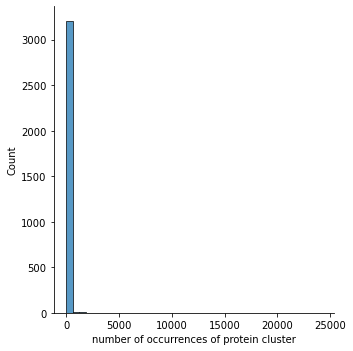

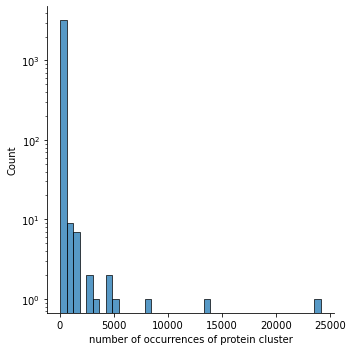

In [8]:
combined_cluster_counts_p = bdb_cluster_counts_p + biolip_cluster_counts_p
combined_cluster_stats_p = get_stats_from_counter(
    counts=combined_cluster_counts_p,
    ntop=30,
    nbins=40,
    name_of_thing_being_counted="protein_cluster_counts",
    xaxis_name="number of occurrences of protein cluster",
    do_show=True,
)

Most commonly occuring protein clusters:

In [9]:
print_counter_stats_df(combined_cluster_stats_p)

Loading... (need help?)


## Distribution of combined ligand clusters

Repeat, but for combined ligand cluster counts:

Total number of entries: 119587
Total number of unique entries: 7053
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


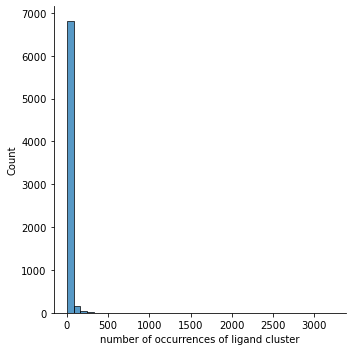

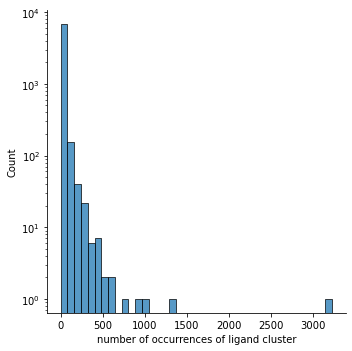

In [10]:
combined_cluster_counts_l = bdb_cluster_counts_l + biolip_cluster_counts_l
combined_cluster_stats_l = get_stats_from_counter(
    counts=combined_cluster_counts_l,
    ntop=30,
    nbins=40,
    name_of_thing_being_counted="ligand_cluster_counts",
    xaxis_name="number of occurrences of ligand cluster",
    do_show=True,
)

Most commonly occuring ligand clusters:

In [11]:
print_counter_stats_df(combined_cluster_stats_l)

Loading... (need help?)


## Distribution of combined (p, l) cluster tuples

Finally, let's look at the distribution of $(p,l)$ cluster tuples in the
combined data:

Total number of entries: 119587
Total number of unique entries: 17419
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


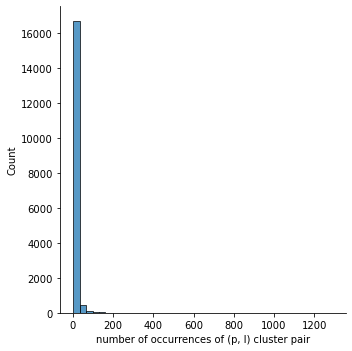

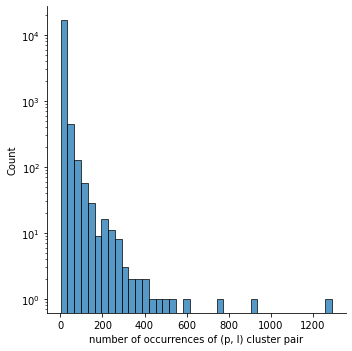

In [12]:
combined_cluster_counts_pl = bdb_cluster_counts_pl + biolip_cluster_counts_pl
combined_cluster_stats_pl = get_stats_from_counter(
    counts=combined_cluster_counts_pl,
    ntop=30,
    nbins=40,
    name_of_thing_being_counted="pl_cluster_pair",
    xaxis_name="number of occurrences of (p, l) cluster pair",
    do_show=True,
)

Most commonly occuring $(p,l)$ cluster tuples:

In [13]:
print_counter_stats_df(combined_cluster_stats_pl)

Loading... (need help?)


We can also generate the same heatmaps as earlier, but showing both BindingDB
and BioLip data on the same plot. This involves reindexing the combined
BindingDB and BioLiP cluster labels. In the first plot, I reindexed both protein
and ligand clusters independently using the same method as on the previous
webpages, but I firstly concatenated the two lists of protein cluster labels (or
ligand cluster labels), specifically, by including the BindingDB labels and then
the BioLiP labels. Because BindingDB comes first here, it gets all the low
indices (0, 1, 2, etc...) for both proteins and ligands, which means its data is
located primarily in the top left quadrant of the plot. Then, the clusters that
appear in BioLiP (but not BindingDB) continue counting up from where BindingDB
left off, which means that they appear mainly in the other three quadrants of
the plot. Keep in mind that some of the BioLiP clusters also appear in
BindingDB, which is why some BioLiP data points appear in the same rows or
columns as the BindingDB data points.

Finally, any $(p,l)$ tuples that appear in both datasets are plotted in a
different colour. If you want to, you can hide any of the three colours in the
plot by clicking on the legend labels.

Anyway, here's the plot:

In [14]:
plot_cluster_counts_bdb_biolip_combined(
    pl_counts_bdb=bdb_cluster_counts_pl,
    pl_counts_biolip=biolip_cluster_counts_pl,
    permute_rows_and_columns=False,
)

And here's the plot with permuted rows and columns, so that most points are near
the top left:

In [15]:
plot_cluster_counts_bdb_biolip_combined(
    pl_counts_bdb=bdb_cluster_counts_pl,
    pl_counts_biolip=biolip_cluster_counts_pl,
    permute_rows_and_columns=True,
)

## Splitting the datasets

In [16]:
# Get variables for the following section

n_bdb_pl = len(bdb_cluster_counts_pl)
n_bdb_p = len(bdb_cluster_counts_p)
n_bdb_l = len(bdb_cluster_counts_l)

myst_nb.glue("n_bdb_pl", n_bdb_pl)
myst_nb.glue("n_bdb_p", n_bdb_p)
myst_nb.glue("n_bdb_l", n_bdb_l)

n_biolip_pl = len(biolip_cluster_counts_pl)
n_biolip_p = len(biolip_cluster_counts_p)
n_biolip_l = len(biolip_cluster_counts_l)

myst_nb.glue("n_biolip_pl", n_biolip_pl)
myst_nb.glue("n_biolip_p", n_biolip_p)
myst_nb.glue("n_biolip_l", n_biolip_l)

n_combined_pl = len(combined_cluster_counts_pl)
n_combined_p = len(combined_cluster_counts_p)
n_combined_l = len(combined_cluster_counts_l)

myst_nb.glue("n_combined_pl", n_combined_pl)
myst_nb.glue("n_combined_p", n_combined_p)
myst_nb.glue("n_combined_l", n_combined_l)

8446

439

4621

9272

2917

3884

17419

3230

7053

The dataset splitting problem can be formulated as follows. Basically, we're
provided with two input datasets, BindingDB and BioLiP, where:

- BindingDB has {glue:}`n_bdb_pl` unique $(p,l)$ tuples, which contain
  {glue:}`n_bdb_p` unique $p$ values and {glue:}`n_bdb_l` $l$ values.

- BioLiP has {glue:}`n_biolip_pl` unique $(p,l)$ tuples, which contain
  {glue:}`n_biolip_p` unique $p$ values and {glue:}`n_biolip_l` $l$ values.

- The combined BindingDB + BioLiP dataset is comprised of {glue:}`n_combined_pl`
  unique $(p,l)$ tuples, where there are {glue:}`n_combined_p` unique $p$ values
  and {glue:}`n_combined_l` unique $l$ values.

```{note}
Some quick observations:
- BindingDB has unusually low protein sequence diversity (i.e. there are only
  {glue:}`n_bdb_p` unique protein clusters)
- Most $p$ and $l$ values are distinct between BioLiP and BindingDB (although
  there are a non-negligible amount that are common to both datasets)
```

In order to train the deep learning model without data leakage, we want to
allocate the input $(p,l)$ tuples into the following three distinct subsets
[^pcts]:

1. Training set, which has approx. 70% of input $(p,l)$ tuples
2. Validation set, which has approx. 15% of input $(p,l)$ tuples
3. Test set, which has approx. 15% of input $(p,l)$ tuples

While subject to the following constraints:
- The number of $(p,l)$ tuples should be roughly balanced between BindingDB and BioLiP
  for each subset
- Each $p$ value may only occur in one of the subsets
- Each $l$ value may only occur in one of the subsets
- We can discard some $(p,l)$ tuples if we need to
  - e.g. if $(1,2)$ is in the training set, and $(3,4)$ is in the validation
    set, then it would be impossible to allocate $(1,4)$ to any of the three
    subsets while meeting the above requirements
- But we want to discard as few $(p,l)$ tuples as possible!

I'm not currently sure what the best way to tackle this problem is. My ad hoc
approaches don't work that well, and I'm not sure if the above constraints are
too strict (e.g. it may require us to discard too many data points?)

[^pcts]: The percentages chosen below are kind of arbitrary, so we can adjust them if we want.